In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
%matplotlib inline

In [89]:
from scipy.stats import skew
from scipy.stats import norm
from scipy.special import boxcox1p, inv_boxcox

In [90]:
from datetime import date, datetime
import time

### Check for Filling

In [91]:
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0
0
0


### Augment feature

In [92]:
def transform_time(d):
    d['time'] = d['datetime'].apply(lambda x: x[11:13])
    d['date'] = d['datetime'].apply(lambda x: x[:10])
    d['weekday'] = d['date'].apply(lambda s: date(*(int(i) for i in s.split('-'))).weekday() + 1)
    d['month'] = d['date'].apply(lambda s: s[5:7])
    d['day'] = d['date'].apply(lambda s: s[8:10])
    d['year'] = d['date'].apply(lambda s: s[:4])

transform_time(train)
transform_time(test)
data = pd.concat([train[test.columns], test]).reset_index(drop=True)

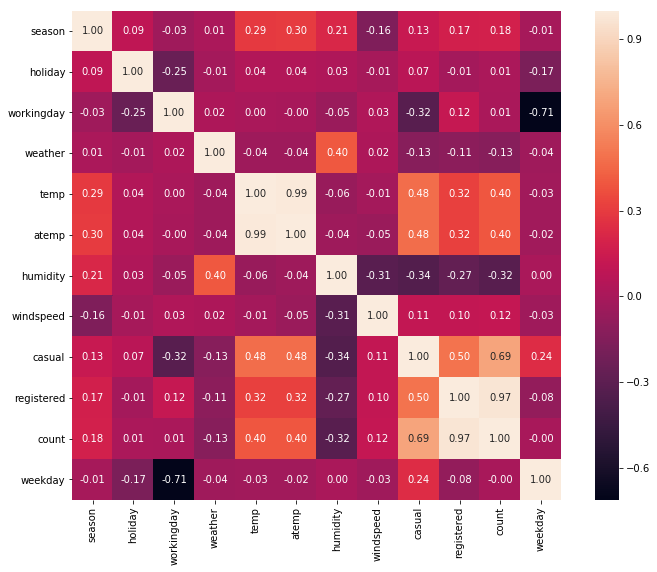

In [93]:
plt.subplots(figsize=(12, 9))
sns.heatmap(train.corr(), square=True, annot=True, fmt='.2f')

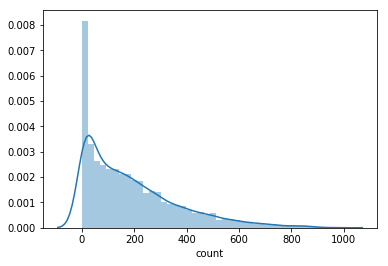

In [94]:
sns.distplot(train['count'])

尝试[Box-Cox](http://onlinestatbook.com/2/transformations/box-cox.html)变换,0.37 使得skew最小,但仍然做log变换。
因为log更符合题目loss函数的要求

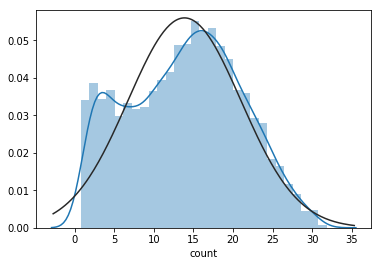

In [95]:
sns.distplot(boxcox1p(train.loc[:, 'count'], 0.37), fit=norm)

skew 一般做到0.75以下，这里没有做到

In [96]:
print(skew(np.log2(train['count'] + 1)), skew(train['count']))

-0.8494341585491002 1.239241376322606


In [97]:
train['count'] = np.log2(train['count'] + 1)
# train['count'] = boxcox1p(train['count'], 0.37)

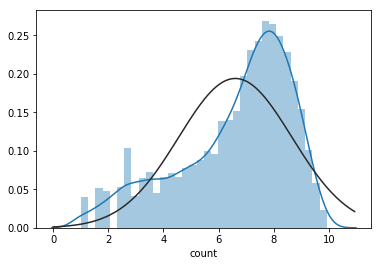

In [98]:
sns.distplot(train['count'], fit=norm)

#### Continuous feature

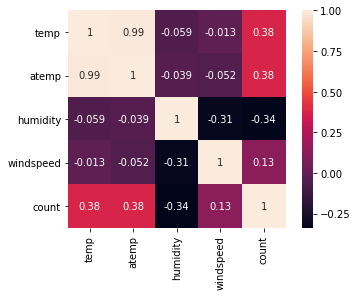

In [99]:
sns.heatmap(train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr(), annot=True, square=True)

In [100]:
value_feature = ['temp', 'atemp', 'humidity', 'windspeed']
skew(train[value_feature])

array([ 0.01835481, -0.09116029, -0.08359535,  0.58037464])

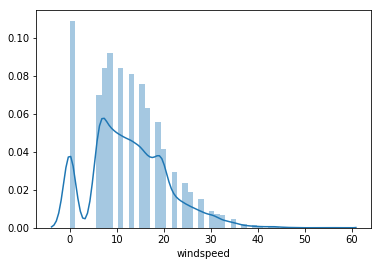

In [101]:
sns.distplot(train['windspeed'])

Text(0,0.5,'temp')

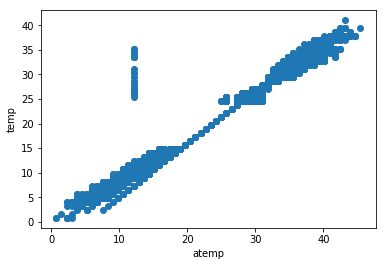

In [102]:
plt.scatter(data['atemp'], data['temp'])
plt.xlabel('atemp')
plt.ylabel('temp')

数据是否有问题？？？

In [103]:
(data['temp'] - data['atemp']).sort_values(ascending=False)[:30]

10444    23.140
10445    23.140
10446    22.320
10443    22.320
10442    21.500
10448    21.500
10447    21.500
10441    19.040
10449    18.220
10440    18.220
10450    17.400
10439    16.580
10438    15.760
10430    15.760
10451    15.760
10432    14.940
10431    14.940
10452    14.940
10433    14.120
10434    14.120
10435    14.120
10453    14.120
10437    14.120
10436    13.300
4920      1.950
4905      1.950
4912      1.825
4911      1.825
4347      1.320
4352      1.195
dtype: float64

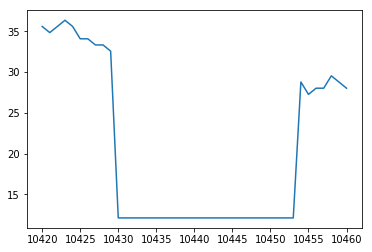

In [104]:
data.loc[10420:10460, 'atemp'].plot()

可以看到有些atemp是错误的，决定删除atemp （删除后小幅度恶化结果）

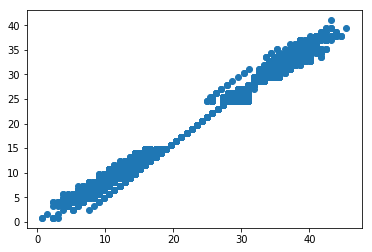

In [105]:
sel = (data['temp'] - data['atemp']).sort_values(ascending=False)[:24].index
data.loc[sel, 'atemp'] = data.loc[sel, 'temp']
plt.scatter(data['atemp'], data['temp'])

In [106]:
data.drop('atemp', axis=1, inplace=True)

#### Discrete feature
Use[BoxPlot](https://baike.baidu.com/item/%E7%AE%B1%E5%BD%A2%E5%9B%BE/10671164?fr=aladdin)

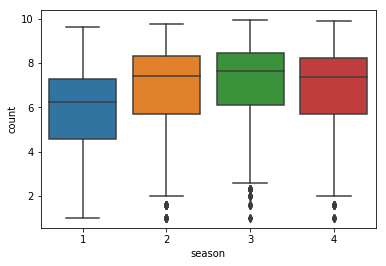

In [107]:
sns.boxplot('season', 'count', data=train)

#### Find the peak hour

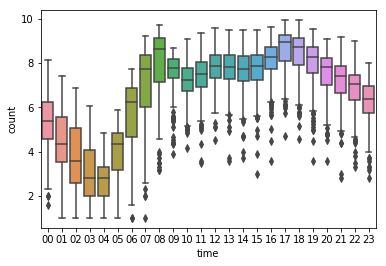

In [108]:
sns.boxplot(train['time'], train['count'])

#### Usage vs. Day of the week

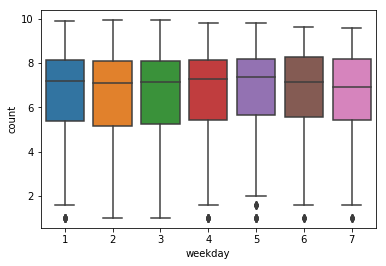

In [109]:
sns.boxplot(train['weekday'], train['count'])

In [110]:
pd.crosstab(data.loc[data['workingday'] == 0, 'holiday'], data.loc[data['workingday'] == 0, 'weekday'])

weekday,1,3,5,6,7
holiday,,,,,
0,0,0,0,1584,1579
1,239,24,48,0,0


In [111]:
pd.crosstab(data.loc[data['workingday'] == 1, 'holiday'], data.loc[data['workingday'] == 1, 'weekday'])

weekday,1,2,3,4,5
holiday,,,,,
0,1312,1539,1527,1553,1481


#### Month and Season contains important information

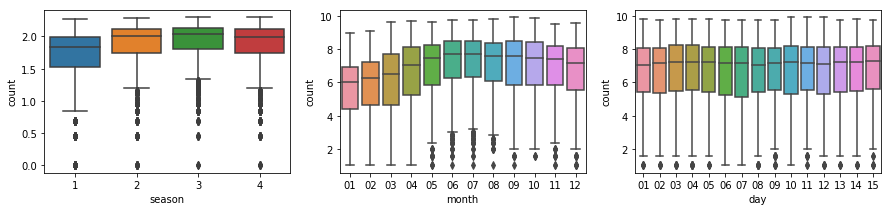

In [112]:
plt.subplots(figsize=(15,3))
plt.subplot(131)
sns.boxplot(train['season'], np.log(train['count']))
plt.subplot(132)
sns.boxplot(train['month'], train['count'])
plt.subplot(133)
sns.boxplot(train['day'], train['count'])

### Year has Gradual Effect

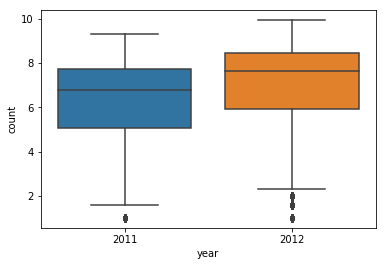

In [113]:
sns.boxplot(train['year'], train['count'])

In [114]:
# Wind?
# from sklearn.ensemble import RandomForestRegressor

# dataWindNot0 = data[data["windspeed"]!=0]
# dataWind0 = data[data['windspeed'] == 0] 
# rfModel_wind = RandomForestRegressor()
# windColumns = ["season","weather","humidity","month","temp","year", "atemp"]
# rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

# data.loc[data["windspeed"]==0, 'windspeed'] = rfModel_wind.predict(X= dataWind0[windColumns])

In [115]:
data = data.drop(['day', 'date', 'datetime'], axis=1)

In [116]:
class_feature = ['weather', 'time', 'weekday', 'month', 'year', 'season']
data = pd.get_dummies(data, columns=class_feature)

### begin to train

In [ ]:
train_X = data[:train.shape[0]]
test_X = data[train.shape[0]:]
train_y = train['count']

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

import xgboost as xgb
import lightgbm as lgb

In [ ]:
def rmse_cv(model):
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, train_X, train_y, scoring="neg_mean_squared_error", cv = kf))  # 默认的cv没有shuffle
    return(rmse.mean())

In [ ]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

### Trying Out models

In [ ]:
ENet = ElasticNet(alpha=0.001)
rmse_cv(ENet)

In [ ]:
lasso = Lasso(alpha=0.001)
rmse_cv(lasso)

In [ ]:
krr = KernelRidge(alpha=1, kernel='polynomial', degree=3)
rmse_cv(krr)

In [ ]:
rfr = RandomForestRegressor(n_estimators=3000, n_jobs=-1)
rmse_cv(rfr)

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber')
# rmse_cv(GBoost)

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.903, gamma=0.048, learning_rate=0.05, max_depth=5, 
                             min_child_weight=0.7817, n_estimators=3000, reg_alpha=0.7640, reg_lambda=0.8571,
                             subsample=0.8213, silent=1, random_state =7, n_jobs = -1)
rmse_cv(model_xgb)

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=40, learning_rate=0.1, n_estimators=500,
                              max_bin = 50, bagging_fraction = 0.5, bagging_freq = 5, feature_fraction = .8,
                              feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =10, 
                              min_sum_hessian_in_leaf = 11)
rmse_cv(model_lgb)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=2)
rmse_cv(knn)

In [ ]:
krr.fit(train_X, train_y)
model_xgb.fit(train_X, train_y)
predict_y = krr.predict(test_X) *0.5 + model_xgb.predict(test_X) * 0.5

In [ ]:
res = pd.DataFrame([test['datetime'].values, 2 ** predict_y - 1], index=['datetime', 'count']).T
res.to_csv('res.csv', index=False, header=True)